In [1]:
import random
import math
from collections import deque
from copy import deepcopy

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical, Dirichlet
from torch.utils.data import DataLoader

In [2]:
2.71828**(-2)

0.13533546530402737

In [3]:
SEED = 1
BATCH_SIZE = 256
LR = 0.03
UP_COEF = 0.01
ENT_COEF = 0.1
GAMMA = 0.99

# set device
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

# random seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed_all(SEED)

In [4]:
class QNet(nn.Module):
    def __init__(self, obs_space, action_space):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(obs_space, 256),
            nn.SELU()
        )

        self.fc = nn.Sequential(
            nn.Linear(256, 256),
            nn.SELU(),
            nn.Linear(256, action_space)
        )

    def forward(self, x):
        out = self.head(x)
        q = self.fc(out).reshape(out.shape[0], -1)

        return q


class PolicyNet(nn.Module):
    def __init__(self, obs_space, action_space):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(obs_space, 256),
            nn.SELU()
        )

        self.fc = nn.Sequential(
            nn.Linear(256, 256),
            nn.SELU(),
            nn.Linear(256, action_space)
        )

        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        out = self.head(x)
        logit = self.fc(out).reshape(out.shape[0], -1)
        log_p = self.log_softmax(logit)

        return log_p


class ValueNet(nn.Module):
    def __init__(self, obs_space):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(obs_space, 256),
            nn.SELU()
        )

        self.fc = nn.Sequential(
            nn.Linear(256, 256),
            nn.SELU(),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        out = self.head(x)
        v = self.fc(out).reshape(out.shape[0], 1)

        return v

In [5]:
losses = []


def learn(q_net, p_net, v_net, v_tgt, q_optim, p_optim, v_optim, rep_memory):
    global action_space
    
    q_net.train()
    p_net.train()
    v_net.train()
    v_tgt.train()

    train_data = random.sample(rep_memory, BATCH_SIZE)
    dataloader = DataLoader(train_data,
                            batch_size=BATCH_SIZE,
                            pin_memory=use_cuda)

    for i, (s, a, r, _s, d) in enumerate(dataloader):
        s_batch = s.to(device).float()
        a_batch = a.to(device).long()
        _s_batch = _s.to(device).float()
        r_batch = r.to(device).float()
        done_mask = 1. - d.to(device).float()
        discount = torch.full_like(r_batch, GAMMA)
        
        q_batch = q_net(s_batch)
        q_acting = q_batch[range(BATCH_SIZE), a_batch]
        q_acting_ = q_acting.detach() 
        
        v_batch = v_net(s_batch)
        
        with torch.no_grad():
            _log_p_batch = p_net(_s_batch)
            _log_p_acting = _log_p_batch[range(BATCH_SIZE), a_batch]
            v_target = q_acting_ - ENT_COEF * _log_p_acting
            
        v_loss = (v_target - v_batch).pow(2).mean()
        v_optim.zero_grad()
        v_loss.backward()
        v_optim.step()
        
        with torch.no_grad():
            _v_batch = v_tgt(_s_batch) * done_mask
            q_target = r_batch + _v_batch * discount
        
        q_loss = (q_target - q_acting).pow(2).mean()
        q_optim.zero_grad()
        q_loss.backward()
        q_optim.step()
        
        log_p_batch = p_net(s_batch)
        q_batch_ = q_net(s_batch) 
        
        p_loss = -((ENT_COEF * log_p_batch) * q_batch_.clamp(min=0.1).log()).sum(dim=1).mean()
        p_optim.zero_grad()
        p_loss.backward()
        p_optim.step()


def select_action(obs, p_net):
    p_net.eval()
    with torch.no_grad():
        state = torch.tensor([obs]).to(device).float()
        log_p = p_net(state)
        m = Categorical(log_p.exp())
        action = m.sample()

    return action.item()

## Main

In [6]:
# make an environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('LunarLander-v2')

env.seed(SEED)
obs_space = env.observation_space.shape[0]
action_space = env.action_space.n

# hyperparameter
n_episodes = 10000
learn_start = 3000
memory_size = 100000
update_frq = 1
use_eps_decay = False
n_eval = env.spec.trials

# global values
total_steps = 0
learn_steps = 0
rewards = []
reward_eval = deque(maxlen=n_eval)
is_learned = False
is_solved = False

# make two nerual networks
q_net = QNet(obs_space, action_space).to(device)
p_net = PolicyNet(obs_space, action_space).to(device)
v_net = ValueNet(obs_space).to(device)
v_tgt = deepcopy(v_net)

# make optimizer
q_optim = optim.Adam(q_net.parameters(), lr=LR)
p_optim = optim.Adam(p_net.parameters(), lr=LR)
v_optim = optim.Adam(v_net.parameters(), lr=LR)

# make a memory
rep_memory = deque(maxlen=memory_size)

In [7]:
env.spec.max_episode_steps

200

In [8]:
env.spec.trials

100

In [9]:
env.spec.reward_threshold

195.0

In [10]:
# play
for i in range(1, n_episodes + 1):
    obs = env.reset()
    done = False
    ep_reward = 0
    while not done:
#         env.render()
        action = select_action(obs, p_net)
        _obs, reward, done, _ = env.step(action)
        rep_memory.append((obs, action, reward, _obs, done))

        obs = _obs
        total_steps += 1
        ep_reward += reward

        if len(rep_memory) >= learn_start:
            if len(rep_memory) == learn_start:
                print('\n============  Start Learning  ============\n')
            learn(q_net, p_net, v_net, v_tgt, q_optim, p_optim, v_optim, rep_memory)
            learn_steps += 1

        if learn_steps == update_frq:
            # target smoothing update
            for t, n in zip(v_tgt.parameters(), v_net.parameters()):
                t.data = UP_COEF * n.data + (1 - UP_COEF) * t.data
            learn_steps = 0
    if done:
        rewards.append(ep_reward)
        reward_eval.append(ep_reward)
        print('{:3} Episode in {:5} steps, reward {:.2f}'.format(
            i, total_steps, ep_reward))

        if len(reward_eval) >= n_eval:
            if np.mean(reward_eval) >= env.spec.reward_threshold:
                print('\n{} is sloved! {:3} Episode in {:3} steps'.format(
                    env.spec.id, i, total_steps))
                torch.save(target_net.state_dict(),
                           f'./test/saved_models/{env.spec.id}_ep{i}_clear_model_sac.pt')
                break
env.close()

  1 Episode in    15 steps, reward 15.00
  2 Episode in    41 steps, reward 26.00
  3 Episode in    52 steps, reward 11.00
  4 Episode in    62 steps, reward 10.00
  5 Episode in    72 steps, reward 10.00
  6 Episode in    89 steps, reward 17.00
  7 Episode in   159 steps, reward 70.00
  8 Episode in   178 steps, reward 19.00
  9 Episode in   193 steps, reward 15.00
 10 Episode in   212 steps, reward 19.00
 11 Episode in   223 steps, reward 11.00
 12 Episode in   240 steps, reward 17.00
 13 Episode in   257 steps, reward 17.00
 14 Episode in   269 steps, reward 12.00
 15 Episode in   279 steps, reward 10.00
 16 Episode in   314 steps, reward 35.00
 17 Episode in   352 steps, reward 38.00
 18 Episode in   368 steps, reward 16.00
 19 Episode in   381 steps, reward 13.00
 20 Episode in   411 steps, reward 30.00
 21 Episode in   432 steps, reward 21.00
 22 Episode in   441 steps, reward 9.00
 23 Episode in   451 steps, reward 10.00
 24 Episode in   466 steps, reward 15.00
 25 Episode in   

200 Episode in  4317 steps, reward 26.00
201 Episode in  4330 steps, reward 13.00
202 Episode in  4347 steps, reward 17.00
203 Episode in  4358 steps, reward 11.00
204 Episode in  4382 steps, reward 24.00
205 Episode in  4439 steps, reward 57.00
206 Episode in  4456 steps, reward 17.00
207 Episode in  4488 steps, reward 32.00
208 Episode in  4512 steps, reward 24.00
209 Episode in  4525 steps, reward 13.00
210 Episode in  4557 steps, reward 32.00
211 Episode in  4574 steps, reward 17.00
212 Episode in  4588 steps, reward 14.00
213 Episode in  4603 steps, reward 15.00
214 Episode in  4626 steps, reward 23.00
215 Episode in  4650 steps, reward 24.00
216 Episode in  4667 steps, reward 17.00
217 Episode in  4706 steps, reward 39.00
218 Episode in  4721 steps, reward 15.00
219 Episode in  4733 steps, reward 12.00
220 Episode in  4766 steps, reward 33.00
221 Episode in  4791 steps, reward 25.00
222 Episode in  4809 steps, reward 18.00
223 Episode in  4826 steps, reward 17.00
224 Episode in  

400 Episode in  8824 steps, reward 14.00
401 Episode in  8843 steps, reward 19.00
402 Episode in  8857 steps, reward 14.00
403 Episode in  8871 steps, reward 14.00
404 Episode in  8891 steps, reward 20.00
405 Episode in  8905 steps, reward 14.00
406 Episode in  8938 steps, reward 33.00
407 Episode in  8952 steps, reward 14.00
408 Episode in  8967 steps, reward 15.00
409 Episode in  9003 steps, reward 36.00
410 Episode in  9013 steps, reward 10.00
411 Episode in  9031 steps, reward 18.00
412 Episode in  9045 steps, reward 14.00
413 Episode in  9060 steps, reward 15.00
414 Episode in  9082 steps, reward 22.00
415 Episode in  9097 steps, reward 15.00
416 Episode in  9110 steps, reward 13.00
417 Episode in  9130 steps, reward 20.00
418 Episode in  9140 steps, reward 10.00
419 Episode in  9209 steps, reward 69.00
420 Episode in  9239 steps, reward 30.00
421 Episode in  9250 steps, reward 11.00
422 Episode in  9270 steps, reward 20.00
423 Episode in  9312 steps, reward 42.00
424 Episode in  

600 Episode in 13016 steps, reward 25.00
601 Episode in 13043 steps, reward 27.00
602 Episode in 13070 steps, reward 27.00
603 Episode in 13088 steps, reward 18.00
604 Episode in 13129 steps, reward 41.00
605 Episode in 13156 steps, reward 27.00
606 Episode in 13188 steps, reward 32.00
607 Episode in 13208 steps, reward 20.00
608 Episode in 13247 steps, reward 39.00
609 Episode in 13274 steps, reward 27.00
610 Episode in 13286 steps, reward 12.00
611 Episode in 13299 steps, reward 13.00
612 Episode in 13331 steps, reward 32.00
613 Episode in 13345 steps, reward 14.00
614 Episode in 13365 steps, reward 20.00
615 Episode in 13404 steps, reward 39.00
616 Episode in 13420 steps, reward 16.00
617 Episode in 13464 steps, reward 44.00
618 Episode in 13491 steps, reward 27.00
619 Episode in 13512 steps, reward 21.00
620 Episode in 13526 steps, reward 14.00
621 Episode in 13545 steps, reward 19.00
622 Episode in 13572 steps, reward 27.00
623 Episode in 13590 steps, reward 18.00
624 Episode in 1

800 Episode in 17695 steps, reward 33.00
801 Episode in 17718 steps, reward 23.00
802 Episode in 17727 steps, reward 9.00
803 Episode in 17745 steps, reward 18.00
804 Episode in 17763 steps, reward 18.00
805 Episode in 17813 steps, reward 50.00
806 Episode in 17826 steps, reward 13.00
807 Episode in 17838 steps, reward 12.00
808 Episode in 17853 steps, reward 15.00
809 Episode in 17863 steps, reward 10.00
810 Episode in 17877 steps, reward 14.00
811 Episode in 17901 steps, reward 24.00
812 Episode in 17915 steps, reward 14.00
813 Episode in 17942 steps, reward 27.00
814 Episode in 17960 steps, reward 18.00
815 Episode in 18002 steps, reward 42.00
816 Episode in 18027 steps, reward 25.00
817 Episode in 18044 steps, reward 17.00
818 Episode in 18064 steps, reward 20.00
819 Episode in 18073 steps, reward 9.00
820 Episode in 18102 steps, reward 29.00
821 Episode in 18156 steps, reward 54.00
822 Episode in 18168 steps, reward 12.00
823 Episode in 18187 steps, reward 19.00
824 Episode in 182

1000 Episode in 22023 steps, reward 21.00
1001 Episode in 22048 steps, reward 25.00
1002 Episode in 22077 steps, reward 29.00
1003 Episode in 22108 steps, reward 31.00
1004 Episode in 22125 steps, reward 17.00
1005 Episode in 22143 steps, reward 18.00
1006 Episode in 22157 steps, reward 14.00
1007 Episode in 22187 steps, reward 30.00
1008 Episode in 22215 steps, reward 28.00
1009 Episode in 22226 steps, reward 11.00
1010 Episode in 22249 steps, reward 23.00
1011 Episode in 22285 steps, reward 36.00
1012 Episode in 22308 steps, reward 23.00
1013 Episode in 22351 steps, reward 43.00
1014 Episode in 22389 steps, reward 38.00
1015 Episode in 22438 steps, reward 49.00
1016 Episode in 22470 steps, reward 32.00
1017 Episode in 22492 steps, reward 22.00
1018 Episode in 22516 steps, reward 24.00
1019 Episode in 22538 steps, reward 22.00
1020 Episode in 22567 steps, reward 29.00
1021 Episode in 22586 steps, reward 19.00
1022 Episode in 22602 steps, reward 16.00
1023 Episode in 22636 steps, rewar

1196 Episode in 26744 steps, reward 11.00
1197 Episode in 26760 steps, reward 16.00
1198 Episode in 26780 steps, reward 20.00
1199 Episode in 26794 steps, reward 14.00
1200 Episode in 26814 steps, reward 20.00
1201 Episode in 26825 steps, reward 11.00
1202 Episode in 26847 steps, reward 22.00
1203 Episode in 26861 steps, reward 14.00
1204 Episode in 26883 steps, reward 22.00
1205 Episode in 26897 steps, reward 14.00
1206 Episode in 26922 steps, reward 25.00
1207 Episode in 26935 steps, reward 13.00
1208 Episode in 26963 steps, reward 28.00
1209 Episode in 26990 steps, reward 27.00
1210 Episode in 27008 steps, reward 18.00
1211 Episode in 27021 steps, reward 13.00
1212 Episode in 27042 steps, reward 21.00
1213 Episode in 27058 steps, reward 16.00
1214 Episode in 27070 steps, reward 12.00
1215 Episode in 27091 steps, reward 21.00
1216 Episode in 27111 steps, reward 20.00
1217 Episode in 27131 steps, reward 20.00
1218 Episode in 27151 steps, reward 20.00
1219 Episode in 27160 steps, rewar

1393 Episode in 31183 steps, reward 29.00
1394 Episode in 31199 steps, reward 16.00
1395 Episode in 31217 steps, reward 18.00
1396 Episode in 31228 steps, reward 11.00
1397 Episode in 31252 steps, reward 24.00
1398 Episode in 31280 steps, reward 28.00
1399 Episode in 31335 steps, reward 55.00
1400 Episode in 31354 steps, reward 19.00
1401 Episode in 31364 steps, reward 10.00
1402 Episode in 31376 steps, reward 12.00
1403 Episode in 31393 steps, reward 17.00
1404 Episode in 31408 steps, reward 15.00
1405 Episode in 31442 steps, reward 34.00
1406 Episode in 31458 steps, reward 16.00
1407 Episode in 31484 steps, reward 26.00
1408 Episode in 31503 steps, reward 19.00
1409 Episode in 31532 steps, reward 29.00
1410 Episode in 31548 steps, reward 16.00
1411 Episode in 31569 steps, reward 21.00
1412 Episode in 31583 steps, reward 14.00
1413 Episode in 31617 steps, reward 34.00
1414 Episode in 31634 steps, reward 17.00
1415 Episode in 31656 steps, reward 22.00
1416 Episode in 31683 steps, rewar

1590 Episode in 35917 steps, reward 17.00
1591 Episode in 35931 steps, reward 14.00
1592 Episode in 35950 steps, reward 19.00
1593 Episode in 35971 steps, reward 21.00
1594 Episode in 36007 steps, reward 36.00
1595 Episode in 36027 steps, reward 20.00
1596 Episode in 36048 steps, reward 21.00
1597 Episode in 36073 steps, reward 25.00
1598 Episode in 36088 steps, reward 15.00
1599 Episode in 36112 steps, reward 24.00
1600 Episode in 36133 steps, reward 21.00
1601 Episode in 36171 steps, reward 38.00
1602 Episode in 36196 steps, reward 25.00
1603 Episode in 36212 steps, reward 16.00
1604 Episode in 36238 steps, reward 26.00
1605 Episode in 36267 steps, reward 29.00
1606 Episode in 36299 steps, reward 32.00
1607 Episode in 36314 steps, reward 15.00
1608 Episode in 36353 steps, reward 39.00
1609 Episode in 36365 steps, reward 12.00
1610 Episode in 36383 steps, reward 18.00
1611 Episode in 36410 steps, reward 27.00
1612 Episode in 36426 steps, reward 16.00
1613 Episode in 36459 steps, rewar

1787 Episode in 40332 steps, reward 14.00
1788 Episode in 40362 steps, reward 30.00
1789 Episode in 40383 steps, reward 21.00
1790 Episode in 40413 steps, reward 30.00
1791 Episode in 40432 steps, reward 19.00
1792 Episode in 40468 steps, reward 36.00
1793 Episode in 40487 steps, reward 19.00
1794 Episode in 40501 steps, reward 14.00
1795 Episode in 40516 steps, reward 15.00
1796 Episode in 40570 steps, reward 54.00
1797 Episode in 40582 steps, reward 12.00
1798 Episode in 40594 steps, reward 12.00
1799 Episode in 40607 steps, reward 13.00
1800 Episode in 40619 steps, reward 12.00
1801 Episode in 40642 steps, reward 23.00
1802 Episode in 40662 steps, reward 20.00
1803 Episode in 40732 steps, reward 70.00
1804 Episode in 40758 steps, reward 26.00
1805 Episode in 40776 steps, reward 18.00
1806 Episode in 40787 steps, reward 11.00
1807 Episode in 40830 steps, reward 43.00
1808 Episode in 40846 steps, reward 16.00
1809 Episode in 40877 steps, reward 31.00
1810 Episode in 40888 steps, rewar

1984 Episode in 44594 steps, reward 20.00
1985 Episode in 44607 steps, reward 13.00
1986 Episode in 44634 steps, reward 27.00
1987 Episode in 44665 steps, reward 31.00
1988 Episode in 44679 steps, reward 14.00
1989 Episode in 44693 steps, reward 14.00
1990 Episode in 44717 steps, reward 24.00
1991 Episode in 44741 steps, reward 24.00
1992 Episode in 44756 steps, reward 15.00
1993 Episode in 44775 steps, reward 19.00
1994 Episode in 44796 steps, reward 21.00
1995 Episode in 44817 steps, reward 21.00
1996 Episode in 44857 steps, reward 40.00
1997 Episode in 44879 steps, reward 22.00
1998 Episode in 44894 steps, reward 15.00
1999 Episode in 44953 steps, reward 59.00
2000 Episode in 44967 steps, reward 14.00
2001 Episode in 44984 steps, reward 17.00
2002 Episode in 45019 steps, reward 35.00
2003 Episode in 45079 steps, reward 60.00
2004 Episode in 45091 steps, reward 12.00
2005 Episode in 45100 steps, reward 9.00
2006 Episode in 45124 steps, reward 24.00
2007 Episode in 45138 steps, reward

2180 Episode in 48953 steps, reward 17.00
2181 Episode in 48968 steps, reward 15.00
2182 Episode in 48992 steps, reward 24.00
2183 Episode in 49014 steps, reward 22.00
2184 Episode in 49034 steps, reward 20.00
2185 Episode in 49046 steps, reward 12.00
2186 Episode in 49069 steps, reward 23.00
2187 Episode in 49082 steps, reward 13.00
2188 Episode in 49126 steps, reward 44.00
2189 Episode in 49139 steps, reward 13.00
2190 Episode in 49151 steps, reward 12.00
2191 Episode in 49172 steps, reward 21.00
2192 Episode in 49206 steps, reward 34.00
2193 Episode in 49227 steps, reward 21.00
2194 Episode in 49240 steps, reward 13.00
2195 Episode in 49278 steps, reward 38.00
2196 Episode in 49300 steps, reward 22.00
2197 Episode in 49315 steps, reward 15.00
2198 Episode in 49346 steps, reward 31.00
2199 Episode in 49367 steps, reward 21.00
2200 Episode in 49383 steps, reward 16.00
2201 Episode in 49396 steps, reward 13.00
2202 Episode in 49411 steps, reward 15.00
2203 Episode in 49430 steps, rewar

2376 Episode in 53718 steps, reward 26.00
2377 Episode in 53731 steps, reward 13.00
2378 Episode in 53762 steps, reward 31.00
2379 Episode in 53779 steps, reward 17.00
2380 Episode in 53828 steps, reward 49.00
2381 Episode in 53841 steps, reward 13.00
2382 Episode in 53854 steps, reward 13.00
2383 Episode in 53890 steps, reward 36.00
2384 Episode in 53904 steps, reward 14.00
2385 Episode in 53925 steps, reward 21.00
2386 Episode in 53946 steps, reward 21.00
2387 Episode in 53982 steps, reward 36.00
2388 Episode in 54004 steps, reward 22.00
2389 Episode in 54016 steps, reward 12.00
2390 Episode in 54029 steps, reward 13.00
2391 Episode in 54044 steps, reward 15.00
2392 Episode in 54067 steps, reward 23.00
2393 Episode in 54079 steps, reward 12.00
2394 Episode in 54091 steps, reward 12.00
2395 Episode in 54106 steps, reward 15.00
2396 Episode in 54126 steps, reward 20.00
2397 Episode in 54150 steps, reward 24.00
2398 Episode in 54165 steps, reward 15.00
2399 Episode in 54175 steps, rewar

2572 Episode in 58079 steps, reward 55.00
2573 Episode in 58104 steps, reward 25.00
2574 Episode in 58123 steps, reward 19.00
2575 Episode in 58140 steps, reward 17.00
2576 Episode in 58158 steps, reward 18.00
2577 Episode in 58172 steps, reward 14.00
2578 Episode in 58185 steps, reward 13.00
2579 Episode in 58201 steps, reward 16.00
2580 Episode in 58214 steps, reward 13.00
2581 Episode in 58235 steps, reward 21.00
2582 Episode in 58248 steps, reward 13.00
2583 Episode in 58277 steps, reward 29.00
2584 Episode in 58306 steps, reward 29.00
2585 Episode in 58332 steps, reward 26.00
2586 Episode in 58342 steps, reward 10.00
2587 Episode in 58380 steps, reward 38.00
2588 Episode in 58393 steps, reward 13.00
2589 Episode in 58439 steps, reward 46.00
2590 Episode in 58477 steps, reward 38.00
2591 Episode in 58490 steps, reward 13.00
2592 Episode in 58503 steps, reward 13.00
2593 Episode in 58527 steps, reward 24.00
2594 Episode in 58544 steps, reward 17.00
2595 Episode in 58559 steps, rewar

2768 Episode in 62607 steps, reward 31.00
2769 Episode in 62627 steps, reward 20.00
2770 Episode in 62638 steps, reward 11.00
2771 Episode in 62662 steps, reward 24.00
2772 Episode in 62694 steps, reward 32.00
2773 Episode in 62719 steps, reward 25.00
2774 Episode in 62736 steps, reward 17.00
2775 Episode in 62752 steps, reward 16.00
2776 Episode in 62769 steps, reward 17.00
2777 Episode in 62791 steps, reward 22.00
2778 Episode in 62806 steps, reward 15.00
2779 Episode in 62832 steps, reward 26.00
2780 Episode in 62844 steps, reward 12.00
2781 Episode in 62888 steps, reward 44.00
2782 Episode in 62927 steps, reward 39.00
2783 Episode in 62949 steps, reward 22.00
2784 Episode in 62963 steps, reward 14.00
2785 Episode in 62974 steps, reward 11.00
2786 Episode in 63022 steps, reward 48.00
2787 Episode in 63035 steps, reward 13.00
2788 Episode in 63048 steps, reward 13.00
2789 Episode in 63092 steps, reward 44.00
2790 Episode in 63105 steps, reward 13.00
2791 Episode in 63129 steps, rewar

2964 Episode in 67385 steps, reward 23.00
2965 Episode in 67415 steps, reward 30.00
2966 Episode in 67437 steps, reward 22.00
2967 Episode in 67484 steps, reward 47.00
2968 Episode in 67501 steps, reward 17.00
2969 Episode in 67517 steps, reward 16.00
2970 Episode in 67531 steps, reward 14.00
2971 Episode in 67584 steps, reward 53.00
2972 Episode in 67594 steps, reward 10.00
2973 Episode in 67622 steps, reward 28.00
2974 Episode in 67644 steps, reward 22.00
2975 Episode in 67682 steps, reward 38.00
2976 Episode in 67701 steps, reward 19.00
2977 Episode in 67733 steps, reward 32.00
2978 Episode in 67759 steps, reward 26.00
2979 Episode in 67775 steps, reward 16.00
2980 Episode in 67794 steps, reward 19.00
2981 Episode in 67815 steps, reward 21.00
2982 Episode in 67847 steps, reward 32.00
2983 Episode in 67878 steps, reward 31.00
2984 Episode in 67913 steps, reward 35.00
2985 Episode in 67934 steps, reward 21.00
2986 Episode in 67958 steps, reward 24.00
2987 Episode in 67976 steps, rewar

3161 Episode in 71973 steps, reward 31.00
3162 Episode in 71986 steps, reward 13.00
3163 Episode in 72004 steps, reward 18.00
3164 Episode in 72020 steps, reward 16.00
3165 Episode in 72044 steps, reward 24.00
3166 Episode in 72065 steps, reward 21.00
3167 Episode in 72095 steps, reward 30.00
3168 Episode in 72115 steps, reward 20.00
3169 Episode in 72139 steps, reward 24.00
3170 Episode in 72159 steps, reward 20.00
3171 Episode in 72192 steps, reward 33.00
3172 Episode in 72245 steps, reward 53.00
3173 Episode in 72263 steps, reward 18.00
3174 Episode in 72283 steps, reward 20.00
3175 Episode in 72327 steps, reward 44.00
3176 Episode in 72361 steps, reward 34.00
3177 Episode in 72380 steps, reward 19.00
3178 Episode in 72391 steps, reward 11.00
3179 Episode in 72417 steps, reward 26.00
3180 Episode in 72434 steps, reward 17.00
3181 Episode in 72497 steps, reward 63.00
3182 Episode in 72516 steps, reward 19.00
3183 Episode in 72530 steps, reward 14.00
3184 Episode in 72568 steps, rewar

3357 Episode in 76710 steps, reward 17.00
3358 Episode in 76732 steps, reward 22.00
3359 Episode in 76763 steps, reward 31.00
3360 Episode in 76781 steps, reward 18.00
3361 Episode in 76809 steps, reward 28.00
3362 Episode in 76835 steps, reward 26.00
3363 Episode in 76851 steps, reward 16.00
3364 Episode in 76877 steps, reward 26.00
3365 Episode in 76899 steps, reward 22.00
3366 Episode in 76922 steps, reward 23.00
3367 Episode in 76946 steps, reward 24.00
3368 Episode in 76967 steps, reward 21.00
3369 Episode in 76980 steps, reward 13.00
3370 Episode in 76999 steps, reward 19.00
3371 Episode in 77019 steps, reward 20.00
3372 Episode in 77039 steps, reward 20.00
3373 Episode in 77072 steps, reward 33.00
3374 Episode in 77081 steps, reward 9.00
3375 Episode in 77097 steps, reward 16.00
3376 Episode in 77133 steps, reward 36.00
3377 Episode in 77144 steps, reward 11.00
3378 Episode in 77156 steps, reward 12.00
3379 Episode in 77176 steps, reward 20.00
3380 Episode in 77224 steps, reward

3554 Episode in 80988 steps, reward 23.00
3555 Episode in 81007 steps, reward 19.00
3556 Episode in 81030 steps, reward 23.00
3557 Episode in 81045 steps, reward 15.00
3558 Episode in 81059 steps, reward 14.00
3559 Episode in 81089 steps, reward 30.00
3560 Episode in 81102 steps, reward 13.00
3561 Episode in 81117 steps, reward 15.00
3562 Episode in 81151 steps, reward 34.00
3563 Episode in 81166 steps, reward 15.00
3564 Episode in 81220 steps, reward 54.00
3565 Episode in 81250 steps, reward 30.00
3566 Episode in 81267 steps, reward 17.00
3567 Episode in 81282 steps, reward 15.00
3568 Episode in 81301 steps, reward 19.00
3569 Episode in 81322 steps, reward 21.00
3570 Episode in 81336 steps, reward 14.00
3571 Episode in 81375 steps, reward 39.00
3572 Episode in 81391 steps, reward 16.00
3573 Episode in 81433 steps, reward 42.00
3574 Episode in 81474 steps, reward 41.00
3575 Episode in 81491 steps, reward 17.00
3576 Episode in 81521 steps, reward 30.00
3577 Episode in 81539 steps, rewar

3750 Episode in 85907 steps, reward 38.00
3751 Episode in 85922 steps, reward 15.00
3752 Episode in 85939 steps, reward 17.00
3753 Episode in 85975 steps, reward 36.00
3754 Episode in 86000 steps, reward 25.00
3755 Episode in 86028 steps, reward 28.00
3756 Episode in 86064 steps, reward 36.00
3757 Episode in 86076 steps, reward 12.00
3758 Episode in 86090 steps, reward 14.00
3759 Episode in 86110 steps, reward 20.00
3760 Episode in 86125 steps, reward 15.00
3761 Episode in 86139 steps, reward 14.00
3762 Episode in 86155 steps, reward 16.00
3763 Episode in 86184 steps, reward 29.00
3764 Episode in 86250 steps, reward 66.00
3765 Episode in 86267 steps, reward 17.00
3766 Episode in 86291 steps, reward 24.00
3767 Episode in 86326 steps, reward 35.00
3768 Episode in 86352 steps, reward 26.00
3769 Episode in 86364 steps, reward 12.00
3770 Episode in 86401 steps, reward 37.00
3771 Episode in 86419 steps, reward 18.00
3772 Episode in 86468 steps, reward 49.00
3773 Episode in 86490 steps, rewar

3946 Episode in 90422 steps, reward 24.00
3947 Episode in 90436 steps, reward 14.00
3948 Episode in 90452 steps, reward 16.00
3949 Episode in 90481 steps, reward 29.00
3950 Episode in 90496 steps, reward 15.00
3951 Episode in 90514 steps, reward 18.00
3952 Episode in 90530 steps, reward 16.00
3953 Episode in 90563 steps, reward 33.00
3954 Episode in 90580 steps, reward 17.00
3955 Episode in 90609 steps, reward 29.00
3956 Episode in 90630 steps, reward 21.00
3957 Episode in 90647 steps, reward 17.00
3958 Episode in 90662 steps, reward 15.00
3959 Episode in 90683 steps, reward 21.00
3960 Episode in 90693 steps, reward 10.00
3961 Episode in 90730 steps, reward 37.00
3962 Episode in 90746 steps, reward 16.00
3963 Episode in 90789 steps, reward 43.00
3964 Episode in 90807 steps, reward 18.00
3965 Episode in 90835 steps, reward 28.00
3966 Episode in 90845 steps, reward 10.00
3967 Episode in 90884 steps, reward 39.00
3968 Episode in 90898 steps, reward 14.00
3969 Episode in 90941 steps, rewar

4142 Episode in 94910 steps, reward 19.00
4143 Episode in 94927 steps, reward 17.00
4144 Episode in 94939 steps, reward 12.00
4145 Episode in 94952 steps, reward 13.00
4146 Episode in 94963 steps, reward 11.00
4147 Episode in 94983 steps, reward 20.00
4148 Episode in 95005 steps, reward 22.00
4149 Episode in 95031 steps, reward 26.00
4150 Episode in 95051 steps, reward 20.00
4151 Episode in 95064 steps, reward 13.00
4152 Episode in 95082 steps, reward 18.00
4153 Episode in 95093 steps, reward 11.00
4154 Episode in 95107 steps, reward 14.00
4155 Episode in 95129 steps, reward 22.00
4156 Episode in 95165 steps, reward 36.00
4157 Episode in 95185 steps, reward 20.00
4158 Episode in 95213 steps, reward 28.00
4159 Episode in 95252 steps, reward 39.00
4160 Episode in 95278 steps, reward 26.00
4161 Episode in 95305 steps, reward 27.00
4162 Episode in 95342 steps, reward 37.00
4163 Episode in 95356 steps, reward 14.00
4164 Episode in 95386 steps, reward 30.00
4165 Episode in 95399 steps, rewar

4338 Episode in 99392 steps, reward 28.00
4339 Episode in 99413 steps, reward 21.00
4340 Episode in 99426 steps, reward 13.00
4341 Episode in 99445 steps, reward 19.00
4342 Episode in 99459 steps, reward 14.00
4343 Episode in 99487 steps, reward 28.00
4344 Episode in 99499 steps, reward 12.00
4345 Episode in 99529 steps, reward 30.00
4346 Episode in 99551 steps, reward 22.00
4347 Episode in 99584 steps, reward 33.00
4348 Episode in 99616 steps, reward 32.00
4349 Episode in 99639 steps, reward 23.00
4350 Episode in 99671 steps, reward 32.00
4351 Episode in 99686 steps, reward 15.00
4352 Episode in 99726 steps, reward 40.00
4353 Episode in 99783 steps, reward 57.00
4354 Episode in 99821 steps, reward 38.00
4355 Episode in 99856 steps, reward 35.00
4356 Episode in 99883 steps, reward 27.00
4357 Episode in 99950 steps, reward 67.00
4358 Episode in 99993 steps, reward 43.00
4359 Episode in 100025 steps, reward 32.00
4360 Episode in 100043 steps, reward 18.00
4361 Episode in 100062 steps, re

4531 Episode in 103821 steps, reward 23.00
4532 Episode in 103837 steps, reward 16.00
4533 Episode in 103854 steps, reward 17.00
4534 Episode in 103873 steps, reward 19.00
4535 Episode in 103882 steps, reward 9.00
4536 Episode in 103911 steps, reward 29.00
4537 Episode in 103936 steps, reward 25.00
4538 Episode in 103957 steps, reward 21.00
4539 Episode in 103982 steps, reward 25.00
4540 Episode in 103996 steps, reward 14.00
4541 Episode in 104014 steps, reward 18.00
4542 Episode in 104031 steps, reward 17.00
4543 Episode in 104051 steps, reward 20.00
4544 Episode in 104070 steps, reward 19.00
4545 Episode in 104104 steps, reward 34.00
4546 Episode in 104138 steps, reward 34.00
4547 Episode in 104152 steps, reward 14.00
4548 Episode in 104162 steps, reward 10.00
4549 Episode in 104175 steps, reward 13.00
4550 Episode in 104195 steps, reward 20.00
4551 Episode in 104218 steps, reward 23.00
4552 Episode in 104249 steps, reward 31.00
4553 Episode in 104262 steps, reward 13.00
4554 Episode

4723 Episode in 107868 steps, reward 16.00
4724 Episode in 107898 steps, reward 30.00
4725 Episode in 107949 steps, reward 51.00
4726 Episode in 107965 steps, reward 16.00
4727 Episode in 107982 steps, reward 17.00
4728 Episode in 108016 steps, reward 34.00
4729 Episode in 108032 steps, reward 16.00
4730 Episode in 108047 steps, reward 15.00
4731 Episode in 108062 steps, reward 15.00
4732 Episode in 108087 steps, reward 25.00
4733 Episode in 108097 steps, reward 10.00
4734 Episode in 108134 steps, reward 37.00
4735 Episode in 108153 steps, reward 19.00
4736 Episode in 108164 steps, reward 11.00
4737 Episode in 108192 steps, reward 28.00
4738 Episode in 108218 steps, reward 26.00
4739 Episode in 108255 steps, reward 37.00
4740 Episode in 108276 steps, reward 21.00
4741 Episode in 108332 steps, reward 56.00
4742 Episode in 108381 steps, reward 49.00
4743 Episode in 108406 steps, reward 25.00
4744 Episode in 108481 steps, reward 75.00
4745 Episode in 108499 steps, reward 18.00
4746 Episod

4915 Episode in 112377 steps, reward 27.00
4916 Episode in 112403 steps, reward 26.00
4917 Episode in 112484 steps, reward 81.00
4918 Episode in 112508 steps, reward 24.00
4919 Episode in 112528 steps, reward 20.00
4920 Episode in 112557 steps, reward 29.00
4921 Episode in 112592 steps, reward 35.00
4922 Episode in 112608 steps, reward 16.00
4923 Episode in 112636 steps, reward 28.00
4924 Episode in 112654 steps, reward 18.00
4925 Episode in 112681 steps, reward 27.00
4926 Episode in 112701 steps, reward 20.00
4927 Episode in 112717 steps, reward 16.00
4928 Episode in 112761 steps, reward 44.00
4929 Episode in 112773 steps, reward 12.00
4930 Episode in 112791 steps, reward 18.00
4931 Episode in 112812 steps, reward 21.00
4932 Episode in 112826 steps, reward 14.00
4933 Episode in 112845 steps, reward 19.00
4934 Episode in 112861 steps, reward 16.00
4935 Episode in 112875 steps, reward 14.00
4936 Episode in 112900 steps, reward 25.00
4937 Episode in 112930 steps, reward 30.00
4938 Episod

5106 Episode in 116806 steps, reward 22.00
5107 Episode in 116823 steps, reward 17.00
5108 Episode in 116846 steps, reward 23.00
5109 Episode in 116866 steps, reward 20.00
5110 Episode in 116881 steps, reward 15.00
5111 Episode in 116906 steps, reward 25.00
5112 Episode in 116921 steps, reward 15.00
5113 Episode in 116964 steps, reward 43.00
5114 Episode in 116992 steps, reward 28.00
5115 Episode in 117002 steps, reward 10.00
5116 Episode in 117032 steps, reward 30.00
5117 Episode in 117058 steps, reward 26.00
5118 Episode in 117066 steps, reward 8.00
5119 Episode in 117089 steps, reward 23.00
5120 Episode in 117109 steps, reward 20.00
5121 Episode in 117133 steps, reward 24.00
5122 Episode in 117163 steps, reward 30.00
5123 Episode in 117177 steps, reward 14.00
5124 Episode in 117209 steps, reward 32.00
5125 Episode in 117242 steps, reward 33.00
5126 Episode in 117266 steps, reward 24.00
5127 Episode in 117290 steps, reward 24.00
5128 Episode in 117316 steps, reward 26.00
5129 Episode

5297 Episode in 121339 steps, reward 31.00
5298 Episode in 121362 steps, reward 23.00
5299 Episode in 121385 steps, reward 23.00
5300 Episode in 121403 steps, reward 18.00
5301 Episode in 121423 steps, reward 20.00
5302 Episode in 121475 steps, reward 52.00
5303 Episode in 121490 steps, reward 15.00
5304 Episode in 121504 steps, reward 14.00
5305 Episode in 121538 steps, reward 34.00
5306 Episode in 121552 steps, reward 14.00
5307 Episode in 121572 steps, reward 20.00
5308 Episode in 121614 steps, reward 42.00
5309 Episode in 121656 steps, reward 42.00
5310 Episode in 121678 steps, reward 22.00
5311 Episode in 121691 steps, reward 13.00
5312 Episode in 121702 steps, reward 11.00
5313 Episode in 121725 steps, reward 23.00
5314 Episode in 121741 steps, reward 16.00
5315 Episode in 121766 steps, reward 25.00
5316 Episode in 121806 steps, reward 40.00
5317 Episode in 121819 steps, reward 13.00
5318 Episode in 121836 steps, reward 17.00
5319 Episode in 121860 steps, reward 24.00
5320 Episod

5489 Episode in 125658 steps, reward 18.00
5490 Episode in 125676 steps, reward 18.00
5491 Episode in 125696 steps, reward 20.00
5492 Episode in 125719 steps, reward 23.00
5493 Episode in 125745 steps, reward 26.00
5494 Episode in 125778 steps, reward 33.00
5495 Episode in 125797 steps, reward 19.00
5496 Episode in 125822 steps, reward 25.00
5497 Episode in 125834 steps, reward 12.00
5498 Episode in 125844 steps, reward 10.00
5499 Episode in 125857 steps, reward 13.00
5500 Episode in 125881 steps, reward 24.00
5501 Episode in 125901 steps, reward 20.00
5502 Episode in 125922 steps, reward 21.00
5503 Episode in 125941 steps, reward 19.00
5504 Episode in 125951 steps, reward 10.00
5505 Episode in 125961 steps, reward 10.00
5506 Episode in 125974 steps, reward 13.00
5507 Episode in 126003 steps, reward 29.00
5508 Episode in 126014 steps, reward 11.00
5509 Episode in 126033 steps, reward 19.00
5510 Episode in 126073 steps, reward 40.00
5511 Episode in 126119 steps, reward 46.00
5512 Episod

5681 Episode in 130125 steps, reward 15.00
5682 Episode in 130154 steps, reward 29.00
5683 Episode in 130180 steps, reward 26.00
5684 Episode in 130196 steps, reward 16.00
5685 Episode in 130224 steps, reward 28.00
5686 Episode in 130267 steps, reward 43.00
5687 Episode in 130301 steps, reward 34.00
5688 Episode in 130315 steps, reward 14.00
5689 Episode in 130341 steps, reward 26.00
5690 Episode in 130369 steps, reward 28.00
5691 Episode in 130381 steps, reward 12.00
5692 Episode in 130396 steps, reward 15.00
5693 Episode in 130428 steps, reward 32.00
5694 Episode in 130443 steps, reward 15.00
5695 Episode in 130454 steps, reward 11.00
5696 Episode in 130469 steps, reward 15.00
5697 Episode in 130484 steps, reward 15.00
5698 Episode in 130512 steps, reward 28.00
5699 Episode in 130527 steps, reward 15.00
5700 Episode in 130542 steps, reward 15.00
5701 Episode in 130566 steps, reward 24.00
5702 Episode in 130594 steps, reward 28.00
5703 Episode in 130627 steps, reward 33.00
5704 Episod

5873 Episode in 134439 steps, reward 15.00
5874 Episode in 134492 steps, reward 53.00
5875 Episode in 134503 steps, reward 11.00
5876 Episode in 134530 steps, reward 27.00
5877 Episode in 134583 steps, reward 53.00
5878 Episode in 134601 steps, reward 18.00
5879 Episode in 134616 steps, reward 15.00
5880 Episode in 134648 steps, reward 32.00
5881 Episode in 134660 steps, reward 12.00
5882 Episode in 134689 steps, reward 29.00
5883 Episode in 134724 steps, reward 35.00
5884 Episode in 134736 steps, reward 12.00
5885 Episode in 134751 steps, reward 15.00
5886 Episode in 134771 steps, reward 20.00
5887 Episode in 134786 steps, reward 15.00
5888 Episode in 134805 steps, reward 19.00
5889 Episode in 134819 steps, reward 14.00
5890 Episode in 134831 steps, reward 12.00
5891 Episode in 134854 steps, reward 23.00
5892 Episode in 134878 steps, reward 24.00
5893 Episode in 134896 steps, reward 18.00
5894 Episode in 134916 steps, reward 20.00
5895 Episode in 134928 steps, reward 12.00
5896 Episod

6064 Episode in 138829 steps, reward 14.00
6065 Episode in 138847 steps, reward 18.00
6066 Episode in 138865 steps, reward 18.00
6067 Episode in 138909 steps, reward 44.00
6068 Episode in 138981 steps, reward 72.00
6069 Episode in 139009 steps, reward 28.00
6070 Episode in 139025 steps, reward 16.00
6071 Episode in 139043 steps, reward 18.00
6072 Episode in 139054 steps, reward 11.00
6073 Episode in 139070 steps, reward 16.00
6074 Episode in 139087 steps, reward 17.00
6075 Episode in 139107 steps, reward 20.00
6076 Episode in 139130 steps, reward 23.00
6077 Episode in 139182 steps, reward 52.00
6078 Episode in 139193 steps, reward 11.00
6079 Episode in 139203 steps, reward 10.00
6080 Episode in 139217 steps, reward 14.00
6081 Episode in 139234 steps, reward 17.00
6082 Episode in 139261 steps, reward 27.00
6083 Episode in 139274 steps, reward 13.00
6084 Episode in 139286 steps, reward 12.00
6085 Episode in 139328 steps, reward 42.00
6086 Episode in 139346 steps, reward 18.00
6087 Episod

6256 Episode in 143124 steps, reward 23.00
6257 Episode in 143152 steps, reward 28.00
6258 Episode in 143172 steps, reward 20.00
6259 Episode in 143187 steps, reward 15.00
6260 Episode in 143207 steps, reward 20.00
6261 Episode in 143239 steps, reward 32.00
6262 Episode in 143257 steps, reward 18.00
6263 Episode in 143267 steps, reward 10.00
6264 Episode in 143282 steps, reward 15.00
6265 Episode in 143314 steps, reward 32.00
6266 Episode in 143351 steps, reward 37.00
6267 Episode in 143382 steps, reward 31.00
6268 Episode in 143423 steps, reward 41.00
6269 Episode in 143433 steps, reward 10.00
6270 Episode in 143475 steps, reward 42.00
6271 Episode in 143515 steps, reward 40.00
6272 Episode in 143540 steps, reward 25.00
6273 Episode in 143564 steps, reward 24.00
6274 Episode in 143583 steps, reward 19.00
6275 Episode in 143600 steps, reward 17.00
6276 Episode in 143614 steps, reward 14.00
6277 Episode in 143654 steps, reward 40.00
6278 Episode in 143669 steps, reward 15.00
6279 Episod

6447 Episode in 148053 steps, reward 19.00
6448 Episode in 148079 steps, reward 26.00
6449 Episode in 148096 steps, reward 17.00
6450 Episode in 148109 steps, reward 13.00
6451 Episode in 148191 steps, reward 82.00
6452 Episode in 148202 steps, reward 11.00
6453 Episode in 148218 steps, reward 16.00
6454 Episode in 148233 steps, reward 15.00
6455 Episode in 148246 steps, reward 13.00
6456 Episode in 148271 steps, reward 25.00
6457 Episode in 148284 steps, reward 13.00
6458 Episode in 148298 steps, reward 14.00
6459 Episode in 148313 steps, reward 15.00
6460 Episode in 148341 steps, reward 28.00
6461 Episode in 148360 steps, reward 19.00
6462 Episode in 148381 steps, reward 21.00
6463 Episode in 148422 steps, reward 41.00
6464 Episode in 148436 steps, reward 14.00
6465 Episode in 148455 steps, reward 19.00
6466 Episode in 148472 steps, reward 17.00
6467 Episode in 148490 steps, reward 18.00
6468 Episode in 148502 steps, reward 12.00
6469 Episode in 148517 steps, reward 15.00
6470 Episod

6639 Episode in 152082 steps, reward 12.00
6640 Episode in 152100 steps, reward 18.00
6641 Episode in 152117 steps, reward 17.00
6642 Episode in 152137 steps, reward 20.00
6643 Episode in 152158 steps, reward 21.00
6644 Episode in 152172 steps, reward 14.00
6645 Episode in 152207 steps, reward 35.00
6646 Episode in 152246 steps, reward 39.00
6647 Episode in 152296 steps, reward 50.00
6648 Episode in 152308 steps, reward 12.00
6649 Episode in 152323 steps, reward 15.00
6650 Episode in 152340 steps, reward 17.00
6651 Episode in 152370 steps, reward 30.00
6652 Episode in 152387 steps, reward 17.00
6653 Episode in 152409 steps, reward 22.00
6654 Episode in 152428 steps, reward 19.00
6655 Episode in 152442 steps, reward 14.00
6656 Episode in 152464 steps, reward 22.00
6657 Episode in 152483 steps, reward 19.00
6658 Episode in 152502 steps, reward 19.00
6659 Episode in 152532 steps, reward 30.00
6660 Episode in 152553 steps, reward 21.00
6661 Episode in 152577 steps, reward 24.00
6662 Episod

6830 Episode in 156269 steps, reward 11.00
6831 Episode in 156293 steps, reward 24.00
6832 Episode in 156333 steps, reward 40.00
6833 Episode in 156367 steps, reward 34.00
6834 Episode in 156381 steps, reward 14.00
6835 Episode in 156391 steps, reward 10.00
6836 Episode in 156401 steps, reward 10.00
6837 Episode in 156428 steps, reward 27.00
6838 Episode in 156440 steps, reward 12.00
6839 Episode in 156460 steps, reward 20.00
6840 Episode in 156476 steps, reward 16.00
6841 Episode in 156491 steps, reward 15.00
6842 Episode in 156501 steps, reward 10.00
6843 Episode in 156512 steps, reward 11.00
6844 Episode in 156541 steps, reward 29.00
6845 Episode in 156578 steps, reward 37.00
6846 Episode in 156623 steps, reward 45.00
6847 Episode in 156636 steps, reward 13.00
6848 Episode in 156647 steps, reward 11.00
6849 Episode in 156663 steps, reward 16.00
6850 Episode in 156682 steps, reward 19.00
6851 Episode in 156703 steps, reward 21.00
6852 Episode in 156743 steps, reward 40.00
6853 Episod

7021 Episode in 160898 steps, reward 53.00
7022 Episode in 160934 steps, reward 36.00
7023 Episode in 160953 steps, reward 19.00
7024 Episode in 161001 steps, reward 48.00
7025 Episode in 161022 steps, reward 21.00
7026 Episode in 161035 steps, reward 13.00
7027 Episode in 161047 steps, reward 12.00
7028 Episode in 161141 steps, reward 94.00
7029 Episode in 161157 steps, reward 16.00
7030 Episode in 161171 steps, reward 14.00
7031 Episode in 161201 steps, reward 30.00
7032 Episode in 161211 steps, reward 10.00
7033 Episode in 161223 steps, reward 12.00
7034 Episode in 161245 steps, reward 22.00
7035 Episode in 161304 steps, reward 59.00
7036 Episode in 161333 steps, reward 29.00
7037 Episode in 161403 steps, reward 70.00
7038 Episode in 161422 steps, reward 19.00
7039 Episode in 161436 steps, reward 14.00
7040 Episode in 161449 steps, reward 13.00
7041 Episode in 161461 steps, reward 12.00
7042 Episode in 161484 steps, reward 23.00
7043 Episode in 161495 steps, reward 11.00
7044 Episod

7212 Episode in 165045 steps, reward 37.00
7213 Episode in 165072 steps, reward 27.00
7214 Episode in 165107 steps, reward 35.00
7215 Episode in 165115 steps, reward 8.00
7216 Episode in 165142 steps, reward 27.00
7217 Episode in 165176 steps, reward 34.00
7218 Episode in 165187 steps, reward 11.00
7219 Episode in 165220 steps, reward 33.00
7220 Episode in 165234 steps, reward 14.00
7221 Episode in 165272 steps, reward 38.00
7222 Episode in 165286 steps, reward 14.00
7223 Episode in 165298 steps, reward 12.00
7224 Episode in 165307 steps, reward 9.00
7225 Episode in 165321 steps, reward 14.00
7226 Episode in 165339 steps, reward 18.00
7227 Episode in 165358 steps, reward 19.00
7228 Episode in 165387 steps, reward 29.00
7229 Episode in 165405 steps, reward 18.00
7230 Episode in 165421 steps, reward 16.00
7231 Episode in 165467 steps, reward 46.00
7232 Episode in 165507 steps, reward 40.00
7233 Episode in 165522 steps, reward 15.00
7234 Episode in 165539 steps, reward 17.00
7235 Episode 

7403 Episode in 169172 steps, reward 27.00
7404 Episode in 169192 steps, reward 20.00
7405 Episode in 169218 steps, reward 26.00
7406 Episode in 169230 steps, reward 12.00
7407 Episode in 169252 steps, reward 22.00
7408 Episode in 169263 steps, reward 11.00
7409 Episode in 169281 steps, reward 18.00
7410 Episode in 169301 steps, reward 20.00
7411 Episode in 169320 steps, reward 19.00
7412 Episode in 169340 steps, reward 20.00
7413 Episode in 169356 steps, reward 16.00
7414 Episode in 169368 steps, reward 12.00
7415 Episode in 169391 steps, reward 23.00
7416 Episode in 169416 steps, reward 25.00
7417 Episode in 169454 steps, reward 38.00
7418 Episode in 169498 steps, reward 44.00
7419 Episode in 169543 steps, reward 45.00
7420 Episode in 169602 steps, reward 59.00
7421 Episode in 169613 steps, reward 11.00
7422 Episode in 169628 steps, reward 15.00
7423 Episode in 169646 steps, reward 18.00
7424 Episode in 169664 steps, reward 18.00
7425 Episode in 169678 steps, reward 14.00
7426 Episod

7595 Episode in 173537 steps, reward 16.00
7596 Episode in 173563 steps, reward 26.00
7597 Episode in 173584 steps, reward 21.00
7598 Episode in 173611 steps, reward 27.00
7599 Episode in 173650 steps, reward 39.00
7600 Episode in 173665 steps, reward 15.00
7601 Episode in 173686 steps, reward 21.00
7602 Episode in 173736 steps, reward 50.00
7603 Episode in 173754 steps, reward 18.00
7604 Episode in 173781 steps, reward 27.00
7605 Episode in 173799 steps, reward 18.00
7606 Episode in 173811 steps, reward 12.00
7607 Episode in 173823 steps, reward 12.00
7608 Episode in 173837 steps, reward 14.00
7609 Episode in 173850 steps, reward 13.00
7610 Episode in 173875 steps, reward 25.00
7611 Episode in 173895 steps, reward 20.00
7612 Episode in 173926 steps, reward 31.00
7613 Episode in 173943 steps, reward 17.00
7614 Episode in 173975 steps, reward 32.00
7615 Episode in 174006 steps, reward 31.00
7616 Episode in 174026 steps, reward 20.00
7617 Episode in 174043 steps, reward 17.00
7618 Episod

7786 Episode in 177666 steps, reward 15.00
7787 Episode in 177681 steps, reward 15.00
7788 Episode in 177699 steps, reward 18.00
7789 Episode in 177724 steps, reward 25.00
7790 Episode in 177736 steps, reward 12.00
7791 Episode in 177753 steps, reward 17.00
7792 Episode in 177763 steps, reward 10.00
7793 Episode in 177783 steps, reward 20.00
7794 Episode in 177798 steps, reward 15.00
7795 Episode in 177821 steps, reward 23.00
7796 Episode in 177842 steps, reward 21.00
7797 Episode in 177853 steps, reward 11.00
7798 Episode in 177869 steps, reward 16.00
7799 Episode in 177926 steps, reward 57.00
7800 Episode in 177941 steps, reward 15.00
7801 Episode in 177987 steps, reward 46.00
7802 Episode in 178000 steps, reward 13.00
7803 Episode in 178016 steps, reward 16.00
7804 Episode in 178029 steps, reward 13.00
7805 Episode in 178052 steps, reward 23.00
7806 Episode in 178085 steps, reward 33.00
7807 Episode in 178105 steps, reward 20.00
7808 Episode in 178126 steps, reward 21.00
7809 Episod

7978 Episode in 181760 steps, reward 24.00
7979 Episode in 181791 steps, reward 31.00
7980 Episode in 181836 steps, reward 45.00
7981 Episode in 181868 steps, reward 32.00
7982 Episode in 181877 steps, reward 9.00
7983 Episode in 181890 steps, reward 13.00
7984 Episode in 181905 steps, reward 15.00
7985 Episode in 181928 steps, reward 23.00
7986 Episode in 181951 steps, reward 23.00
7987 Episode in 181967 steps, reward 16.00
7988 Episode in 181984 steps, reward 17.00
7989 Episode in 182034 steps, reward 50.00
7990 Episode in 182043 steps, reward 9.00
7991 Episode in 182055 steps, reward 12.00
7992 Episode in 182072 steps, reward 17.00
7993 Episode in 182094 steps, reward 22.00
7994 Episode in 182116 steps, reward 22.00
7995 Episode in 182131 steps, reward 15.00
7996 Episode in 182180 steps, reward 49.00
7997 Episode in 182208 steps, reward 28.00
7998 Episode in 182222 steps, reward 14.00
7999 Episode in 182233 steps, reward 11.00
8000 Episode in 182244 steps, reward 11.00
8001 Episode 

8169 Episode in 186224 steps, reward 21.00
8170 Episode in 186244 steps, reward 20.00
8171 Episode in 186254 steps, reward 10.00
8172 Episode in 186274 steps, reward 20.00
8173 Episode in 186287 steps, reward 13.00
8174 Episode in 186300 steps, reward 13.00
8175 Episode in 186317 steps, reward 17.00
8176 Episode in 186358 steps, reward 41.00
8177 Episode in 186368 steps, reward 10.00
8178 Episode in 186392 steps, reward 24.00
8179 Episode in 186443 steps, reward 51.00
8180 Episode in 186454 steps, reward 11.00
8181 Episode in 186474 steps, reward 20.00
8182 Episode in 186493 steps, reward 19.00
8183 Episode in 186514 steps, reward 21.00
8184 Episode in 186571 steps, reward 57.00
8185 Episode in 186589 steps, reward 18.00
8186 Episode in 186601 steps, reward 12.00
8187 Episode in 186628 steps, reward 27.00
8188 Episode in 186681 steps, reward 53.00
8189 Episode in 186702 steps, reward 21.00
8190 Episode in 186738 steps, reward 36.00
8191 Episode in 186770 steps, reward 32.00
8192 Episod

8361 Episode in 190604 steps, reward 10.00
8362 Episode in 190645 steps, reward 41.00
8363 Episode in 190663 steps, reward 18.00
8364 Episode in 190686 steps, reward 23.00
8365 Episode in 190699 steps, reward 13.00
8366 Episode in 190712 steps, reward 13.00
8367 Episode in 190733 steps, reward 21.00
8368 Episode in 190802 steps, reward 69.00
8369 Episode in 190819 steps, reward 17.00
8370 Episode in 190834 steps, reward 15.00
8371 Episode in 190870 steps, reward 36.00
8372 Episode in 190881 steps, reward 11.00
8373 Episode in 190911 steps, reward 30.00
8374 Episode in 190931 steps, reward 20.00
8375 Episode in 190952 steps, reward 21.00
8376 Episode in 190973 steps, reward 21.00
8377 Episode in 190985 steps, reward 12.00
8378 Episode in 191020 steps, reward 35.00
8379 Episode in 191036 steps, reward 16.00
8380 Episode in 191049 steps, reward 13.00
8381 Episode in 191070 steps, reward 21.00
8382 Episode in 191083 steps, reward 13.00
8383 Episode in 191107 steps, reward 24.00
8384 Episod

8553 Episode in 195107 steps, reward 14.00
8554 Episode in 195126 steps, reward 19.00
8555 Episode in 195137 steps, reward 11.00
8556 Episode in 195171 steps, reward 34.00
8557 Episode in 195198 steps, reward 27.00
8558 Episode in 195216 steps, reward 18.00
8559 Episode in 195231 steps, reward 15.00
8560 Episode in 195250 steps, reward 19.00
8561 Episode in 195261 steps, reward 11.00
8562 Episode in 195298 steps, reward 37.00
8563 Episode in 195314 steps, reward 16.00
8564 Episode in 195337 steps, reward 23.00
8565 Episode in 195355 steps, reward 18.00
8566 Episode in 195389 steps, reward 34.00
8567 Episode in 195408 steps, reward 19.00
8568 Episode in 195445 steps, reward 37.00
8569 Episode in 195456 steps, reward 11.00
8570 Episode in 195472 steps, reward 16.00
8571 Episode in 195492 steps, reward 20.00
8572 Episode in 195502 steps, reward 10.00
8573 Episode in 195516 steps, reward 14.00
8574 Episode in 195532 steps, reward 16.00
8575 Episode in 195561 steps, reward 29.00
8576 Episod

8744 Episode in 199608 steps, reward 57.00
8745 Episode in 199634 steps, reward 26.00
8746 Episode in 199650 steps, reward 16.00
8747 Episode in 199679 steps, reward 29.00
8748 Episode in 199689 steps, reward 10.00
8749 Episode in 199707 steps, reward 18.00
8750 Episode in 199719 steps, reward 12.00
8751 Episode in 199740 steps, reward 21.00
8752 Episode in 199769 steps, reward 29.00
8753 Episode in 199783 steps, reward 14.00
8754 Episode in 199810 steps, reward 27.00
8755 Episode in 199830 steps, reward 20.00
8756 Episode in 199873 steps, reward 43.00
8757 Episode in 199895 steps, reward 22.00
8758 Episode in 199918 steps, reward 23.00
8759 Episode in 199931 steps, reward 13.00
8760 Episode in 199946 steps, reward 15.00
8761 Episode in 199985 steps, reward 39.00
8762 Episode in 199996 steps, reward 11.00
8763 Episode in 200013 steps, reward 17.00
8764 Episode in 200026 steps, reward 13.00
8765 Episode in 200097 steps, reward 71.00
8766 Episode in 200110 steps, reward 13.00
8767 Episod

8935 Episode in 204004 steps, reward 20.00
8936 Episode in 204032 steps, reward 28.00
8937 Episode in 204061 steps, reward 29.00
8938 Episode in 204094 steps, reward 33.00
8939 Episode in 204115 steps, reward 21.00
8940 Episode in 204132 steps, reward 17.00
8941 Episode in 204163 steps, reward 31.00
8942 Episode in 204195 steps, reward 32.00
8943 Episode in 204227 steps, reward 32.00
8944 Episode in 204265 steps, reward 38.00
8945 Episode in 204284 steps, reward 19.00
8946 Episode in 204302 steps, reward 18.00
8947 Episode in 204313 steps, reward 11.00
8948 Episode in 204358 steps, reward 45.00
8949 Episode in 204379 steps, reward 21.00
8950 Episode in 204403 steps, reward 24.00
8951 Episode in 204424 steps, reward 21.00
8952 Episode in 204453 steps, reward 29.00
8953 Episode in 204469 steps, reward 16.00
8954 Episode in 204482 steps, reward 13.00
8955 Episode in 204512 steps, reward 30.00
8956 Episode in 204534 steps, reward 22.00
8957 Episode in 204572 steps, reward 38.00
8958 Episod

9126 Episode in 208292 steps, reward 16.00
9127 Episode in 208308 steps, reward 16.00
9128 Episode in 208373 steps, reward 65.00
9129 Episode in 208385 steps, reward 12.00
9130 Episode in 208399 steps, reward 14.00
9131 Episode in 208409 steps, reward 10.00
9132 Episode in 208453 steps, reward 44.00
9133 Episode in 208500 steps, reward 47.00
9134 Episode in 208539 steps, reward 39.00
9135 Episode in 208561 steps, reward 22.00
9136 Episode in 208596 steps, reward 35.00
9137 Episode in 208624 steps, reward 28.00
9138 Episode in 208644 steps, reward 20.00
9139 Episode in 208668 steps, reward 24.00
9140 Episode in 208686 steps, reward 18.00
9141 Episode in 208702 steps, reward 16.00
9142 Episode in 208714 steps, reward 12.00
9143 Episode in 208751 steps, reward 37.00
9144 Episode in 208763 steps, reward 12.00
9145 Episode in 208777 steps, reward 14.00
9146 Episode in 208802 steps, reward 25.00
9147 Episode in 208820 steps, reward 18.00
9148 Episode in 208839 steps, reward 19.00
9149 Episod

9317 Episode in 212899 steps, reward 17.00
9318 Episode in 212921 steps, reward 22.00
9319 Episode in 212931 steps, reward 10.00
9320 Episode in 212943 steps, reward 12.00
9321 Episode in 212963 steps, reward 20.00
9322 Episode in 212976 steps, reward 13.00
9323 Episode in 213026 steps, reward 50.00
9324 Episode in 213041 steps, reward 15.00
9325 Episode in 213054 steps, reward 13.00
9326 Episode in 213088 steps, reward 34.00
9327 Episode in 213114 steps, reward 26.00
9328 Episode in 213139 steps, reward 25.00
9329 Episode in 213161 steps, reward 22.00
9330 Episode in 213174 steps, reward 13.00
9331 Episode in 213207 steps, reward 33.00
9332 Episode in 213253 steps, reward 46.00
9333 Episode in 213272 steps, reward 19.00
9334 Episode in 213292 steps, reward 20.00
9335 Episode in 213315 steps, reward 23.00
9336 Episode in 213343 steps, reward 28.00
9337 Episode in 213365 steps, reward 22.00
9338 Episode in 213383 steps, reward 18.00
9339 Episode in 213408 steps, reward 25.00
9340 Episod

9510 Episode in 217181 steps, reward 14.00
9511 Episode in 217198 steps, reward 17.00
9512 Episode in 217215 steps, reward 17.00
9513 Episode in 217245 steps, reward 30.00
9514 Episode in 217267 steps, reward 22.00
9515 Episode in 217291 steps, reward 24.00
9516 Episode in 217313 steps, reward 22.00
9517 Episode in 217324 steps, reward 11.00
9518 Episode in 217342 steps, reward 18.00
9519 Episode in 217374 steps, reward 32.00
9520 Episode in 217408 steps, reward 34.00
9521 Episode in 217424 steps, reward 16.00
9522 Episode in 217457 steps, reward 33.00
9523 Episode in 217509 steps, reward 52.00
9524 Episode in 217521 steps, reward 12.00
9525 Episode in 217562 steps, reward 41.00
9526 Episode in 217597 steps, reward 35.00
9527 Episode in 217609 steps, reward 12.00
9528 Episode in 217630 steps, reward 21.00
9529 Episode in 217643 steps, reward 13.00
9530 Episode in 217667 steps, reward 24.00
9531 Episode in 217681 steps, reward 14.00
9532 Episode in 217702 steps, reward 21.00
9533 Episod

9701 Episode in 221937 steps, reward 35.00
9702 Episode in 221969 steps, reward 32.00
9703 Episode in 221981 steps, reward 12.00
9704 Episode in 222001 steps, reward 20.00
9705 Episode in 222022 steps, reward 21.00
9706 Episode in 222040 steps, reward 18.00
9707 Episode in 222063 steps, reward 23.00
9708 Episode in 222089 steps, reward 26.00
9709 Episode in 222100 steps, reward 11.00
9710 Episode in 222117 steps, reward 17.00
9711 Episode in 222130 steps, reward 13.00
9712 Episode in 222142 steps, reward 12.00
9713 Episode in 222158 steps, reward 16.00
9714 Episode in 222195 steps, reward 37.00
9715 Episode in 222230 steps, reward 35.00
9716 Episode in 222245 steps, reward 15.00
9717 Episode in 222265 steps, reward 20.00
9718 Episode in 222282 steps, reward 17.00
9719 Episode in 222295 steps, reward 13.00
9720 Episode in 222328 steps, reward 33.00
9721 Episode in 222355 steps, reward 27.00
9722 Episode in 222366 steps, reward 11.00
9723 Episode in 222396 steps, reward 30.00
9724 Episod

9892 Episode in 226794 steps, reward 14.00
9893 Episode in 226805 steps, reward 11.00
9894 Episode in 226836 steps, reward 31.00
9895 Episode in 226868 steps, reward 32.00
9896 Episode in 226913 steps, reward 45.00
9897 Episode in 226924 steps, reward 11.00
9898 Episode in 226977 steps, reward 53.00
9899 Episode in 226989 steps, reward 12.00
9900 Episode in 227008 steps, reward 19.00
9901 Episode in 227033 steps, reward 25.00
9902 Episode in 227046 steps, reward 13.00
9903 Episode in 227061 steps, reward 15.00
9904 Episode in 227079 steps, reward 18.00
9905 Episode in 227090 steps, reward 11.00
9906 Episode in 227109 steps, reward 19.00
9907 Episode in 227138 steps, reward 29.00
9908 Episode in 227153 steps, reward 15.00
9909 Episode in 227187 steps, reward 34.00
9910 Episode in 227206 steps, reward 19.00
9911 Episode in 227232 steps, reward 26.00
9912 Episode in 227273 steps, reward 41.00
9913 Episode in 227309 steps, reward 36.00
9914 Episode in 227320 steps, reward 11.00
9915 Episod

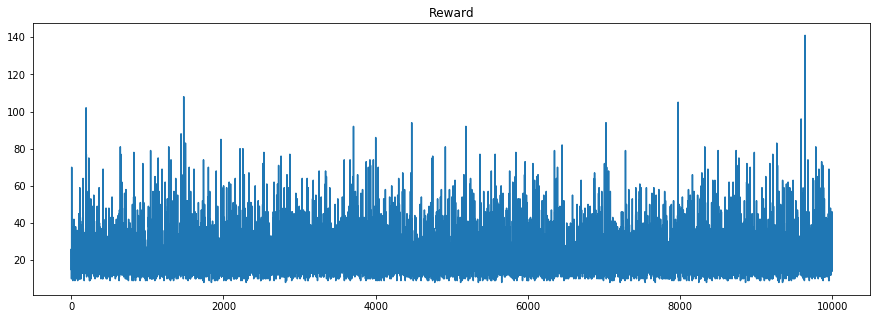

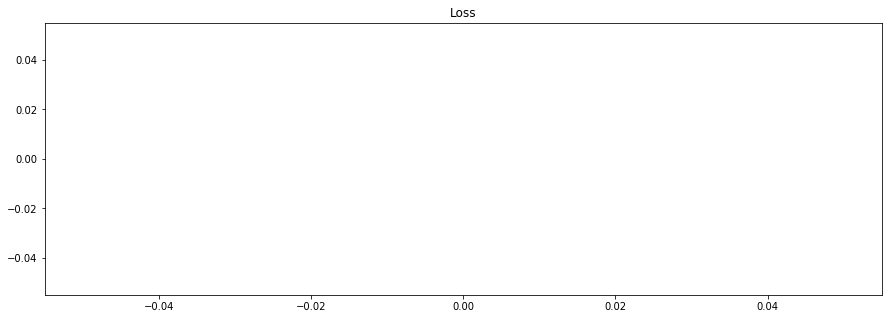

In [11]:
plt.figure(figsize=(15, 5))
plt.title('Reward')
plt.plot(rewards)
plt.figure(figsize=(15, 5))
plt.title('Loss')
plt.plot(losses)
plt.show()

In [12]:
[
    ('CartPole-v0', 299, 0.25),
    ('CartPole-v1', 413, 0.025),
    ('MountainCar-v0', None ,0.05)
]

[('CartPole-v0', 299, 0.25),
 ('CartPole-v1', 413, 0.025),
 ('MountainCar-v0', None, 0.05)]